In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm 
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
from time import sleep
plt.rc('font', size=24)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('figure', titlesize=30)  # fontsize of the figure title
def pretty(X):
    return pd.DataFrame(X)
d = 2
def plotDataPoints(ax,**kwargs):
#     fig,ax = plt.subplots()
    colors  = kwargs.pop('color',["#F44336","#536DFE","#4CAF50","#FF9800"])
    markers = kwargs.pop("marker",["*"]*4)
    data   = [_w0,_w1,_w2,_w3]
    labels = ["$\omega_0$","$\omega_1$","$\omega_2$","$\omega_3$"]
    for i,v in enumerate(data):
        ax.scatter(v[:,0],v[:,1],color=colors[i],label=labels[i],**kwargs,marker=markers[i])
    ax.legend()

In [261]:
df     = pd.read_csv("data1.txt",delimiter="\t",header=None)
c      = int(df.shape[1]/d)
w0     = np.hstack([df.iloc[:,:2],np.full((10,1),0)])
_w0    = w0[:,:2]
w1     = np.hstack([df.iloc[:,2:4],np.full((10,1),1)])
_w1    = w1[:,:2]
w2     = np.hstack([df.iloc[:,4:6],np.full((10,1),2)])
_w2    = w2[:,:2]
w3     = np.hstack([df.iloc[:,6:],np.full((10,1),3)])
_w3    = w3[:,:2]
X      = np.concatenate([w0,w1,w2,w3])
_Xdf   = pretty(X).rename(columns = {0:'x1',1:'x2',2:'class'},inplace=False)
_Xdf['class']= _Xdf['class'].astype('int')
_X     = X[:,:2]
target = X[:,2]
wi     = [_w0,_w1,_w2,_w3]

10

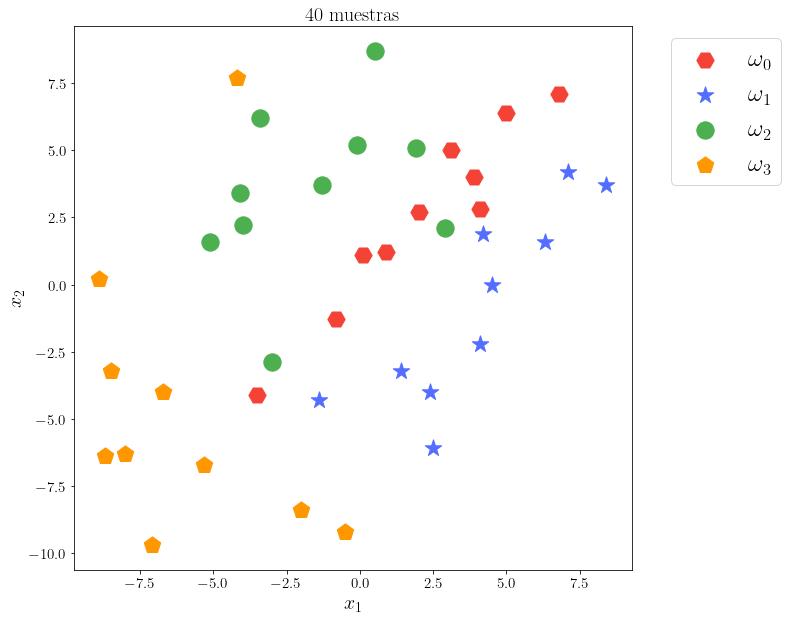

In [403]:
_,ax = plt.subplots(figsize=(10,10))
plotDataPoints(ax,marker=["H","*","o","p"],s=300)
ax.set_title("40 muestras")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend(bbox_to_anchor=(1.05, 1))
# plt.tight_layout()
plt.savefig("images/01.png")

# Practica #1:  Riesgo condicional

a) Implemente el calculo del vector de medias, matriz de covarianza y probabilidad a priori definidas en
las Ecuaciones 32–34 de la clase AD-03. No se permite el uso de funciones predefinidas en bibliotecas o
toolboxes.

## Vector de medias

In [213]:
def mean(x):
    return x.sum(axis=0)/x.shape[0]

Vector de medias para la clase w1

In [404]:
w0_mean = mean(_w0)
w0_mean

array([2.16, 2.49])

Vector de medias para la clase w2

In [405]:
w1_mean = mean(_w1)
w1_mean

array([ 3.95, -0.84])

Vector de medias para la clase w3

In [406]:
w2_mean = mean(_w2)
w2_mean

array([-1.57,  3.53])

Vector de medias para la clase w4

In [407]:
w3_mean = mean(_w3)
w3_mean

array([-5.99, -4.6 ])

In [408]:
uk = [w0_mean,w1_mean,w2_mean,w3_mean]

# Matriz de covarianza

In [409]:
def cov(x,uk):
    ni = x.shape[0]
    d  = x.shape[1]
    matrix = np.zeros((d,d))
    for i in range(d):
        X  = x[:,i]
        for j in range(d):
            Y=x[:,j]
            matrix[i][j]= ((X-uk[i])*(Y-uk[j])).sum()/(ni-1)
    return matrix

Matriz de covarianza para la clase w1

In [410]:
w0_cov = cov(_w0,w0_mean)
w0_cov

array([[ 9.32488889, 10.11733333],
       [10.11733333, 11.84988889]])

Matriz de covarianza para la clase w2

In [411]:
w1_cov = cov(_w1,w1_mean)
w1_cov

array([[ 8.36277778,  8.86777778],
       [ 8.86777778, 13.02488889]])

Matriz de covarianza para la clase w3

In [222]:
w2_cov = cov(_w2,w2_mean)
w2_cov

array([[7.63344444, 2.99344444],
       [2.99344444, 9.78233333]])

Matriz de covarianza para la clase w4

In [223]:
w3_cov = cov(_w3,w3_mean)
w3_cov

array([[ 8.62544444, -2.64444444],
       [-2.64444444, 27.64444444]])

In [224]:
covX = [w0_cov,w1_cov,w2_cov,w3_cov]

# Probabilidad a priori

In [225]:
data=[_w0,_w1,_w2,_w3]
total = sum(list(map(lambda x:x.shape[0],data)))

Probabilidad a priori de la clase w1

In [226]:
Pw0 = _w0.shape[0]/total
Pw0

0.25

Probabilidad a priori de la clase w2

In [227]:
Pw1 = _w1.shape[0]/total
Pw1

0.25

Probabilidad a priori de la clase w3

In [228]:
Pw2 = _w2.shape[0]/total
Pw2

0.25

Probabilidad a priori de la clase w4

In [229]:
Pw3 = _w3.shape[0]/total
Pw3

0.25

In [239]:
Pwi = [Pw0,Pw1,Pw2,Pw3]
Pwi

[0.25, 0.25, 0.25, 0.25]

b) Use las funciones en el inciso (a) para calcular las probabilidades posteriores de cada muestra en la
Tabla 1, implementado la Ecuaci´on 1 de la clase AD-03. La funcion de verosimilitud esta dada por la
funcion de densidad Gaussiana multivariante (Ecuacion 10 de la clase AD-03).

# Funcion de densidad Gaussiana Multivariante

In [412]:
def px(x,ui,sigmai,pwi):
    d  = x.shape[0]
    sigmaDet = np.linalg.det(sigmai)
    denominator = 1/(np.power(2*np.pi,d/2) * np.power(sigmaDet,0.5))
    sigmaIv     = np.linalg.inv(sigmai)
    xMinusMean  = (x-ui)
    xMinusMeanT = -0.5*xMinusMean.T 
    exp         = np.exp(xMinusMeanT@sigmaIv@xMinusMean)
    return denominator*exp

# Funcion discriminante Bayesiana

In [413]:
def gix(x,wIndex):
    parameters  = zip(uk,covX,Pwi)
    denominator = np.array(list(map (lambda params: px(x,*params),parameters)))
    return (denominator[wIndex]*Pwi[wIndex]) / denominator.sum()

def bayesClassifier(x):
    data = []
    for i in range(c):
        data.append(gix(x,i))
    return np.argmax(np.array(data))


## Grafica 2D del clasificador bayesiano

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

Processing(1):   0%|          | 0/40 [00:00<?, ?it/s]

Rendering(1):   0%|          | 0/40 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Clasificador Bayesiano'}, xlabel='$x_1$', ylabel='$x_2$'>

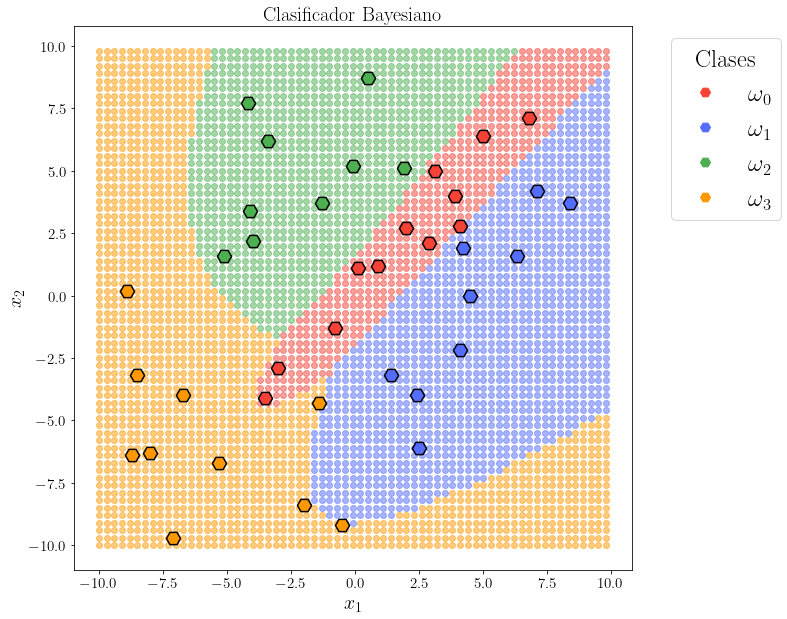

In [433]:
plot_classifier(bayes_fx,
                title="Clasificador Bayesiano",
                plot_step=.3,
                filename="bayes",
                edgecolor="#000",
                save_img=True
               )

c) Calcule el riesgo condicional de las muestras de entrenamiento (Ecuaci´on 19 de la clase AD-02).

#  Riesgo condicional

In [421]:
def lambdaAlphaiWj(i,j):
    return 0 if(i==j) else 1

def _rc(i,xi):
    res = 0
    for j in range(c):
        res+= lambdaAlphaiWj(i,j)*gix(xi,j)
    return res
def conditionalRisk(i,xs):
    for xi in xs:
        val = _rc(i,xi)
        print("Riesgo condicional para la muestra {0} -> {1}".format(xi,val))
        
for i,data in enumerate([_w0,_w1,_w2,_w3]):
    print("_"*100)
    print("Verdadero estado de naturaleza w{0}, para las muestras de la clase w{0}".format(i))
    print("_"*100)
    conditionalRisk(i,data)
    print("_"*100)

____________________________________________________________________________________________________
Verdadero estado de naturaleza w0, para las muestras de la clase w0
____________________________________________________________________________________________________
Riesgo condicional para la muestra [0.1 1.1] -> 0.06283717870755821
Riesgo condicional para la muestra [6.8 7.1] -> 0.012427011179442827
Riesgo condicional para la muestra [-3.5 -4.1] -> 0.11922169385513018
Riesgo condicional para la muestra [2.  2.7] -> 0.02902643464867076
Riesgo condicional para la muestra [4.1 2.8] -> 0.12201664734158821
Riesgo condicional para la muestra [3.1 5. ] -> 0.06017645407570857
Riesgo condicional para la muestra [-0.8 -1.3] -> 0.04259186137090271
Riesgo condicional para la muestra [0.9 1.2] -> 0.03224861058787194
Riesgo condicional para la muestra [5.  6.4] -> 0.012707536833703261
Riesgo condicional para la muestra [3.9 4. ] -> 0.01811244662738775
____________________________________________

# Práctica #2

a) Use las funciones en el inciso (a) de la Practica #1 para entrenar un clasificador basado en funciones
discriminantes Gaussianas cuadraticas (Ecuacion 26 de la clase AD-03)

## Funcion discriminante cuadratica

In [422]:
def _gix(xi,covs,uk,pw):
    result = []
    for i in range(c):
        w_cov     = covs[i] 
        ui        = uk[i]
        pwi       = pw[i] 
        sigmaIv   = np.linalg.inv(w_cov)
        Wi        = -0.5 * sigmaIv
        wi        = sigmaIv@ui
        sigma_det = np.linalg.det(w_cov)
        w0i       = -0.5*ui.T@sigmaIv@ui-0.5*np.log(sigma_det)+np.log(pwi)
        xiT       = xi.T
        res       = xiT@Wi@xi + wi.T@xi+w0i
        result.append(res)
        
    return np.argmax(result)

## Grafica 2D del clasificador basadado en funciones discriminantes guassianas Cuadraticas

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

Processing(1):   0%|          | 0/40 [00:00<?, ?it/s]

Rendering(1):   0%|          | 0/40 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Clasificador Cuadratico'}, xlabel='$x_1$', ylabel='$x_2$'>

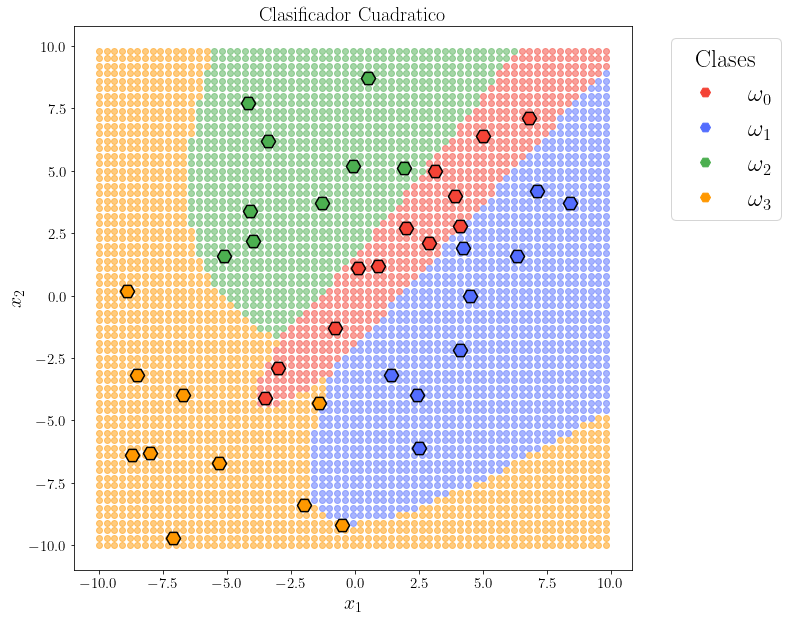

In [434]:
plot_classifier(quadratic_fx,title="Clasificador Cuadratico",plot_step=.3,filename="quadratic",save_img=True)

# Practica #3

a) A partir de los datos en la Tabla 1, use las funciones en el inciso (a) de la Practica #1 para entrenar un clasificador de mınima distancia Euclidiana y un clasificador de mınima distancia Mahalanobis
(Ecuaciones 18 y 23 de la clase AD-03).

In [424]:
def cMinEucli(x,uk):
    result = []
    for i in range(c):
        ui         = uk[i]
        xMinusMean = x-ui
        res =np.sqrt(xMinusMean.T@xMinusMean)
        result.append(res)
    return np.argmin(np.array(result))
#     return result

def cMinMaha(x,uk,sigmas):
    result = []
    combined_sigma             = np.zeros((2,2))
    combined_sigma_denominator =  0
    for i in range(c):
        ni = wi[i].shape[0]
        combined_sigma_denominator+= 1/(ni-1)
        combined_sigma            += (ni-1)*sigmas[i]
    combined_sigma = combined_sigma*combined_sigma_denominator
        
    for i in range(c):
        ui         = uk[i]
        sigmaInv   = np.linalg.inv(combined_sigma)
        xMinusMean = x-ui
        res = np.sqrt(xMinusMean.T@sigmaInv@xMinusMean)
        result.append(res)
    return np.argmin(np.array(result))

# Grafica 2D Clasificador de minima distancia euclidiana

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

Processing(1):   0%|          | 0/40 [00:00<?, ?it/s]

Rendering(1):   0%|          | 0/40 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Clasificador de minima distancia Euclidiana'}, xlabel='$x_1$', ylabel='$x_2$'>

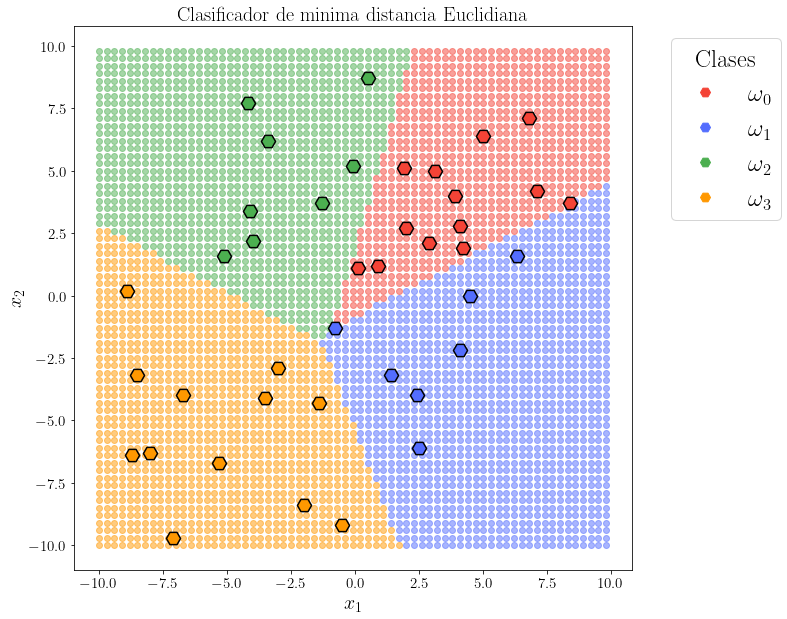

In [435]:
plot_classifier(med_fx,title="Clasificador de minima distancia Euclidiana",plot_step=.3,filename="mde",save_img=True)

# Grafica 2D Clasificador de minima distancia Mahalanobis

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

Processing(1):   0%|          | 0/40 [00:00<?, ?it/s]

Rendering(1):   0%|          | 0/40 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Clasificador de minima distancia Mahalanobis'}, xlabel='$x_1$', ylabel='$x_2$'>

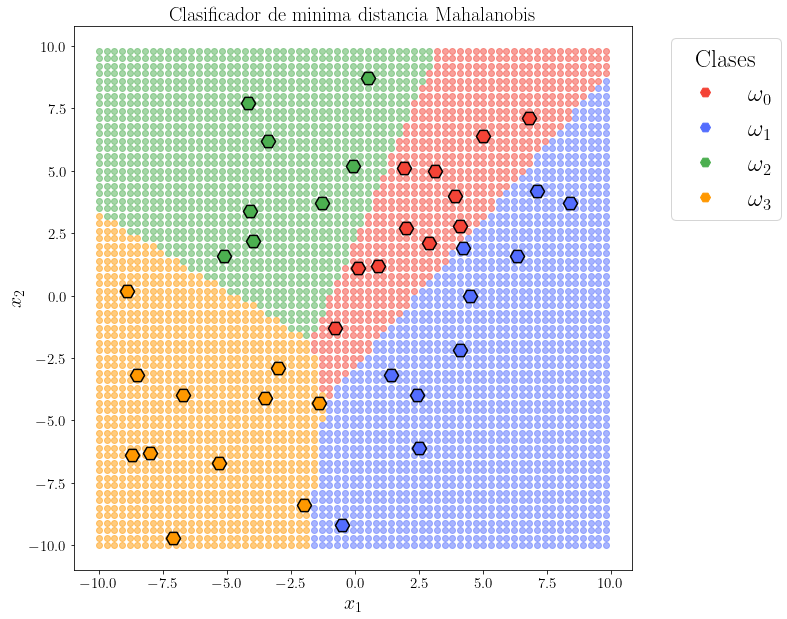

In [436]:
plot_classifier(mmd,title="Clasificador de minima distancia Mahalanobis",plot_step=.3,filename="mmd",save_img=True)

b) Clasifique los siguientes patrones de prueba: $\mathbf{x_1} = [-1.7,-2.6]^T$, $\mathbf{x_2}=[0.3,-7.6]^T,\mathbf{x_3}=[-7.3,5.0]^T y \quad \mathbf{x_4}=[5.6,2.8]^T$, usando los dos clasificadores implementados en el inciso anterior, asi como el clasificador
cuadratico implementado en la Practica #2.

In [388]:
x1 = np.array([-1.7,-2.6])
x2 = np.array([0.3,-7.6])
x3 = np.array([-7.3,5.0])
x4 = np.array([5.6,2.8])
data = [x1,x2,x3,x4]
def classifyPatterns(data,fx,**kwargs):
    filename = kwargs.get("filename","default")
    title    = kwargs.get("title","default")
    names = ['x1','x2','x3','x4']
    colors        = ["#F44336","#536DFE","#4CAF50","#FF9800"]
    ax= plot_classifier(fx,title=title,plot_step=.3,filename=filename,show_patterns=False)
    for i,xi in enumerate(data):
        val = fx(xi)
        label = "$\mathbf{x}_"+str(i+1)+ "\longrightarrow w_"+str(val)+"$"
        ax.scatter(xi[0],xi[1],color=colors[val],s=500,edgecolors="#000",label=label)
    ax.legend(bbox_to_anchor=(1.05, 1),title="Patrones")
    plt.savefig("images/{}".format(filename),dpi=300,bbox_inches='tight')

### Clasificador cuadratico

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

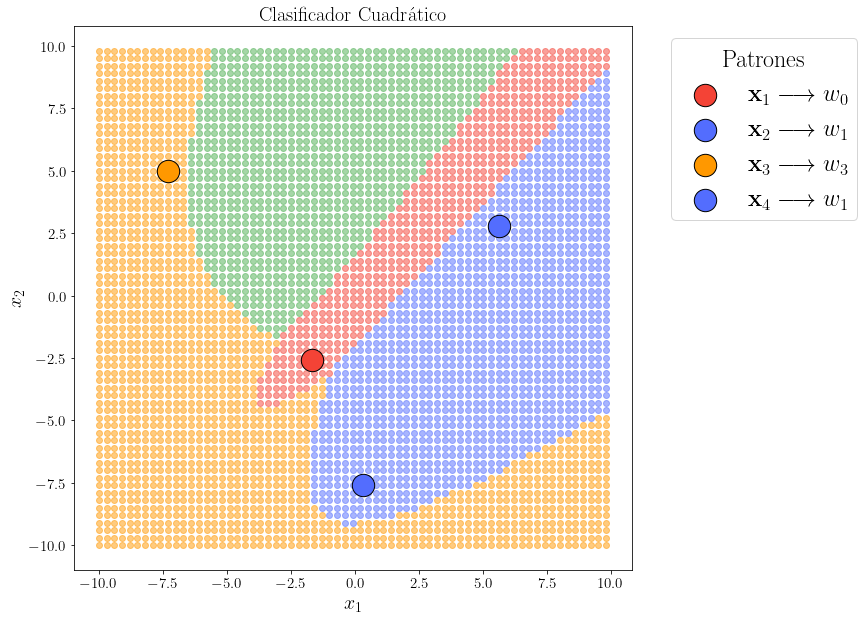

In [389]:
classifyPatterns(data,quadratic_fx,filename="quadratic_3",title="Clasificador Cuadrático")

### Clasificador de minima distancia Euclidiana

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

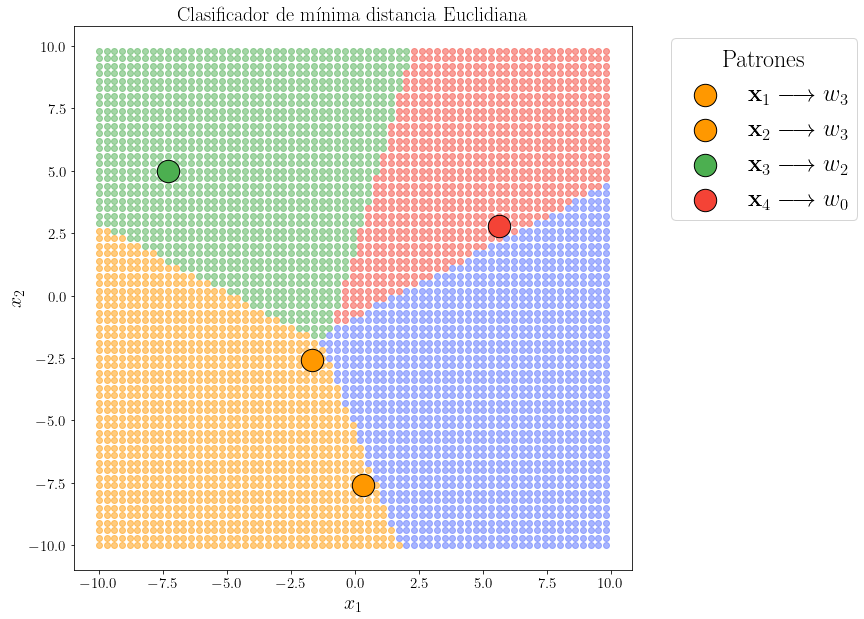

In [390]:
classifyPatterns(data,med_fx,filename="mde_3",title="Clasificador de mínima distancia Euclidiana")

### Clasificador de minima distancia Mahalanobis

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

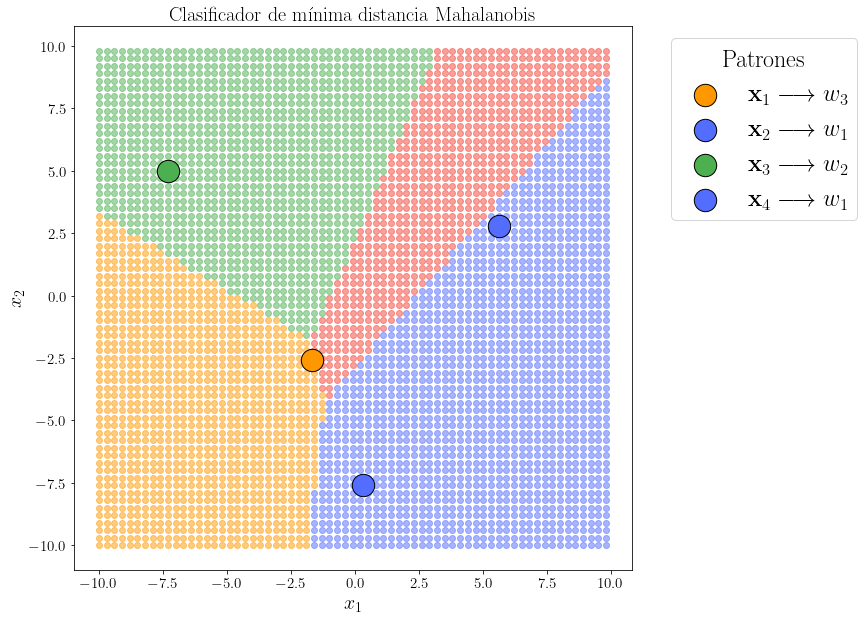

In [391]:
classifyPatterns(data,mmd,filename="mmd_3",title="Clasificador de mínima distancia Mahalanobis")

### Clasificador Bayesiano

Processing(0):   0%|          | 0/67 [00:00<?, ?it/s]

Rendering(0):   0%|          | 0/4 [00:00<?, ?it/s]

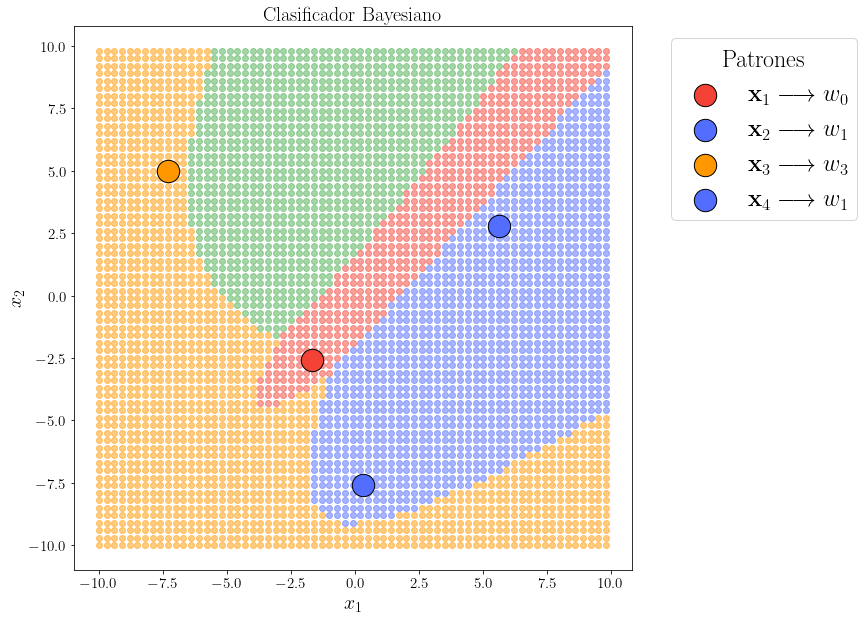

In [392]:
classifyPatterns(data,bayes_fx,filename="bayes_3",title="Clasificador Bayesiano")

In [393]:
def get_accuracy(fx):
    target_pred=np.zeros((40))
    for i,x in enumerate(_X):
        target_pred[i]=fx(x)

    acc = target_pred == target
    acc =(target.shape[0] - np.bitwise_not(acc).sum())/target.shape[0]
    return acc
get_accuracy(bayes_fx),get_accuracy(quadratic_fx),get_accuracy(med_fx),get_accuracy(mmd)

(0.9, 0.9, 0.75, 0.825)

In [432]:
def plot_classifier(fx,**kwargs):
    show_patterns = kwargs.get("show_patterns",True)
    save          = kwargs.get("save_img",False)
    colors        = kwargs.get("colors",["#F44336","#536DFE","#4CAF50","#FF9800"])
    labels        = ["$\omega_0$","$\omega_1$","$\omega_2$","$\omega_3$"]
    plot_step     = kwargs.get('plot_step',1)
    filename      = kwargs.get("filename","01")
    edgecolor     = kwargs.get("edgecolor","#000")
    xMin          = -10
    xMax          = 10
    x             = np.arange(xMin, xMax , plot_step)
    y             = np.arange(xMin,xMax,plot_step)
    xx , yy       = np.meshgrid(x,y)
    _,ax          = plt.subplots(figsize=(10,10))
#     data          = []
    title         = kwargs.get('title',"Clasificador")
    _data =dict()
    with tqdm(total=xx.shape[0],desc="Processing(0)") as pbar:
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                x1      = xx[i][j]
                x2      = yy[i][j]
                outcome = fx(np.array([x1,x2]))
#                 data.append((x1,x2,outcome))
                if not outcome  in _data:
                    _data[outcome] =[]
                _data[outcome].append([x1,x2])
            pbar.update(1)
    
#     print(_data)
    with tqdm(total=len(_data),desc="Rendering(0)") as pbar:
        for key, value in _data.items():
            _value = np.array(value)
            ax.scatter(_value[:,0],_value[:,1],color=colors[key],alpha=.5)
            pbar.update(1)

    if(show_patterns):
        data =[]
        with tqdm(total=_X.shape[0],desc="Processing(1)") as pbar:
            for x in  _X:
                outcome = fx(np.array([x[0],x[1]]))
                data.append((x[0],x[1],outcome))
                pbar.update(1)

        with tqdm(total=len(data),desc ="Rendering(1)") as pbar:
            for (x1,x2,color) in data:
                ax.scatter(x1,x2,
                           color=colors[color],
                           alpha=1,
                           marker="H",
                           s=200,
                           edgecolor=edgecolor,
                           linewidth=1.5
                          )
                pbar.update(1)

    ax.set_title(title)
#     ax.set_title("Clasificador Bayesiano")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    markers =list(
       map( lambda x: Line2D([], [], 
               marker='H', 
               color=x[0],
               label=x[1], 
               markersize=10,
               linestyle='',
#                linewidth=2
              ),zip(colors,labels)
    ) )
    ax.legend(handles=markers,bbox_to_anchor=(1.05, 1),title="Clases")
    if(save):
        plt.savefig("images/{}".format(filename),bbox_inches='tight',dpi=300)
    
    return ax
def bayes_fx(xi):
    return bayesClassifier(xi)
def quadratic_fx(xi):
    return _gix(xi,covX,uk,Pwi)
def med_fx(xi):
    return cMinEucli(xi,uk)
def mmd(xi):
    return cMinMaha(xi,uk,covX)